# WISE BPIC 2019 – Deep-Dive Analysis and Improvement Guide

This notebook-style Markdown builds on your existing BPIC'19 analysis and the
exported tables:

- `features.csv` – per-case engineered features
- `Case_Full.csv` – summary per spend area
- `Aggregated Scores.csv` – WISE slice-level scores

and extends them with:

- clear explanation of **shrunk** scores,
- additional **heatmaps** and visualisations of the worst slices,
- **SHAP** and **LIME** to explain WISE badness in terms of engineered features,
- business-oriented interpretation and a structured list of **process
  improvement ideas** for the BPIC'19 P2P domain.

You can convert this file to a Jupyter notebook using:

In [1]:
%%bash
#jupytext --to ipynb WISE_BPIC19_DeepDive.md

---

## 0. Imports and data loading

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set_theme(style="whitegrid")

# set path for loading data from /Users/ula/code/PhD/WISE/WISE/Untitled/src/wise/analysis/data/results_BPIC_2019
data_path = Path("/Users/ula/code/PhD/WISE/WISE/Untitled/src/wise/analysis/data/results_BPIC_2019")

data = {
    "df_subset" : pd.read_csv(data_path / "df_subset_3-way_match_invoice_after_GR.csv"),
    "case_features" : pd.read_csv(data_path / "case_features_3-way_match_invoice_after_GR.csv"),
    "case_scores" : pd.read_csv(data_path / "case_scores_3-way_match_invoice_after_GR.csv"),
    "case_full" : pd.read_csv(data_path / "case_full_3-way_match_invoice_after_GR.csv"),
    "slice_summary" : pd.read_csv(data_path / "slice_summary_3-way_match_invoice_after_GR.csv"),

}

Load the CSVs you exported from your earlier analysis.

In [3]:
DATA_DIR = Path("data")  # adapt to your folder structure

features = data["case_features"]
case_full = data["case_full"]
slice_summary = data["slice_summary"]

features.head(), case_full.head(), slice_summary.head()

(  case concept:name             first_po             first_gr  \
 0  2000000001_00001  2018-01-03 10:49:00  2018-01-16 13:09:00   
 1  2000000002_00001  2018-01-04 15:17:00  2018-02-06 15:53:00   
 2  2000000005_00002  2018-01-08 11:09:00                  NaN   
 3  2000000006_00001  2018-01-08 12:33:00  2018-01-09 10:04:00   
 4  2000000008_00001  2018-01-08 16:36:00  2018-01-15 12:53:00   
 
              first_inv          first_clear  po_to_gr_days  gr_to_inv_days  \
 0  2018-01-16 15:44:00  2018-03-08 13:21:00           13.0             0.0   
 1  2018-08-16 12:41:00  2018-08-16 15:03:00           33.0           190.0   
 2                  NaN                  NaN            NaN             NaN   
 3  2018-01-09 12:59:00  2018-02-23 12:14:00            0.0             0.0   
 4  2018-01-17 15:49:00  2018-02-22 16:18:00            6.0             2.0   
 
    inv_to_clear_days  n_events  n_gr  ...  n_manual_events  auto_ratio  \
 0               50.0        15     1  ...         

### 0.1. Quick recap: what are these tables?

- `features.csv` – one row per case (PO line item) with:

  - timestamps: `first_po`, `first_gr`, `first_inv`, `first_clear`,
  - lead times (in days): `po_to_gr_days`, `gr_to_inv_days`, `inv_to_clear_days`,
  - event counts: `n_events`, `n_gr`, `n_inv`, `n_clear`, `n_price_changes`,
  - users: `n_users`,
  - calendar: `start_ts`, `start_dow`, `start_month`,
  - automation: `n_auto_events`, `n_manual_events`, `auto_ratio`,
  - multiplicity: `n_multi_activities`, `sum_multi_events`,
    `n_multi_change_activities`, `sum_multi_change_events`,
  - behavioural cluster: `cluster`.

- `Case_Full.csv` – spend-area level summary of WISE scores
  (e.g. count, mean, quantiles per `case Spend area text`).

- `Aggregated Scores.csv` – slice-level aggregation used for WISE, likely with
  columns such as:

  - `case Company`,
  - `case Spend area text`,
  - `case Item Category`,
  - `cluster`, `complexity_cluster`, `auto_level`,
  - `n_cases`,
  - `mean_score`, `shrunk_score`.

We will use:

- `features` + `score` to explain **case-level badness** with SHAP/LIME,
- `slice_summary` to understand **slice-level priorities** (and shrinkage),
- `case_full` to interpret spend-area distributions.

---

## 1. Understanding shrunk scores and Priority Index

### 1.1. Raw vs shrunk WISE scores

`Aggregated Scores.csv` typically contains columns like:

In [4]:
slice_summary.columns

Index(['case Company', 'case Spend area text', 'case Item Category', 'cluster',
       'complexity_cluster', 'auto_level', 'n_cases', 'mean_score',
       'shrunk_score'],
      dtype='object')

We assume that it includes:

- `n_cases` – number of cases in the slice,
- `mean_score` – average WISE score for that slice,
- `shrunk_score` – mean score after Empirical-Bayes shrinkage.

Mathematically, the shrunk mean is:

$$
\tilde{\mu}_s = \frac{n_s \mu_s + k\,\mu_{\mathrm{global}}}{n_s + k}
$$

where

- $ \mu_s $ is the slice mean,
- $ \mu_{\mathrm{global}} $ is the global mean across all cases,
- $ n_s $ is the slice size,
- $ k $ is a smoothing parameter (e.g. $k = 50$).

**Intuition.**

- Large slices (many cases) keep their own mean.
- Tiny slices are pulled towards the global mean to avoid overreacting to noise.

Let us visualise this.

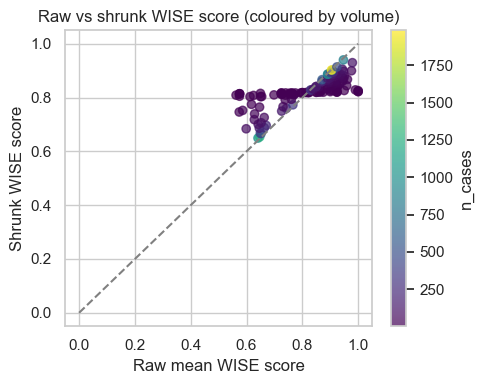

In [5]:
# if column names differ, adapt these
mean_col = "mean_score"
shrunk_col = "shrunk_score"

global_mean = slice_summary[mean_col].mean()

plt.figure(figsize=(5,4))
plt.scatter(slice_summary[mean_col], slice_summary[shrunk_col],
            c=slice_summary["n_cases"], cmap="viridis", alpha=0.7)
plt.plot([0,1],[0,1], "--", color="gray")
plt.colorbar(label="n_cases")
plt.xlabel("Raw mean WISE score")
plt.ylabel("Shrunk WISE score")
plt.title("Raw vs shrunk WISE score (coloured by volume)")
plt.tight_layout()
plt.show()

**Business interpretation.**

This plot shows that:

- big slices (many cases) sit close to the diagonal → we trust their scores;
- small slices with extreme raw means are moved closer to the global mean;
- shrunk scores are therefore a **safer basis for ranking** slices in a
  governance setting, because they do not elevate tiny segments based on a
  handful of unusual cases.

### 1.2. Gap and Priority Index (PI)

To identify the worst slices, it is often useful to combine **severity** and
**volume** into a simple Priority Index:

In [6]:
slice_summary["gap"] = global_mean - slice_summary[mean_col]
slice_summary["gap_pos"] = slice_summary["gap"].clip(lower=0)  # only worse-than-global
slice_summary["PI"] = slice_summary["gap_pos"] * slice_summary["n_cases"]
slice_summary.sort_values("PI", ascending=False).head(10)

,case Company,case Spend area text,case Item Category,cluster,complexity_cluster,auto_level,n_cases,mean_score,shrunk_score,gap,gap_pos,PI
1,companyID_0000,Logistics,"3-way match, invoice after GR",1,_3,NaN,1261,0.647351,0.653895,0.166900,0.166900,210.460902
0,companyID_0000,Logistics,"3-way match, invoice after GR",1,_1,NaN,1006,0.641091,0.649511,0.173160,0.173160,174.199318
2,companyID_0000,Packaging,"3-way match, invoice after GR",1,_1,NaN,537,0.652210,0.666410,0.162042,0.162042,87.016287
3,companyID_0000,Logistics,"3-way match, invoice after GR",3,_3,NaN,419,0.649463,0.667529,0.164788,0.164788,69.046299
6,companyID_0000,Sales,"3-way match, invoice after GR",1,_1,NaN,266,0.663647,0.688215,0.150605,0.150605,40.060849
7,companyID_0000,Trading & End Products,"3-way match, invoice after GR",1,_1,NaN,234,0.670481,0.696615,0.143771,0.143771,33.642307
5,companyID_0000,CAPEX & SOCS,"3-way match, invoice after GR",1,_1,NaN,164,0.645884,0.686313,0.168367,0.168367,27.612215
8,companyID_0000,Logistics,"3-way match, invoice after GR",1,_2,NaN,101,0.641832,0.700470,0.172420,0.172420,17.414382
4,companyID_0000,NaN,"3-way match, invoice after GR",1,_1,NaN,79,0.598734,0.684078,0.215517,0.215517,17.025854
9,companyID_0000,Marketing,"3-way match, invoice after GR",1,_1,NaN,104,0.652380,0.706451,0.161872,0.161872,16.834636


- `gap > 0` → slice is worse than global average,
- `PI` = gap × volume → slices with **many bad cases** get highest priority.

Visualise severity vs volume:

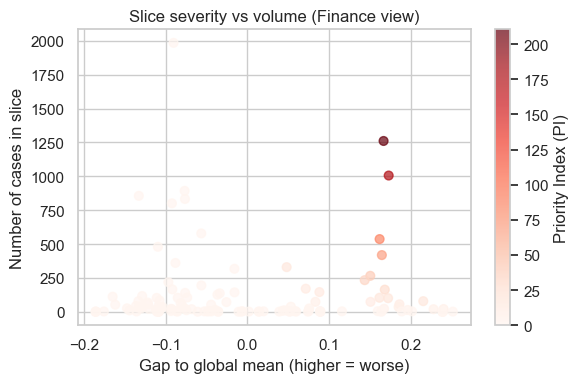

In [7]:
plt.figure(figsize=(6,4))
plt.scatter(slice_summary["gap"], slice_summary["n_cases"],
            s=40, alpha=0.7, c=slice_summary["PI"], cmap="Reds")
plt.xlabel("Gap to global mean (higher = worse)")
plt.ylabel("Number of cases in slice")
plt.title("Slice severity vs volume (Finance view)")
plt.colorbar(label="Priority Index (PI)")
plt.tight_layout()
plt.show()

> The top-right dark points are your **first candidates** for deeper analysis
> and subsequent improvement projects.

---

## 2. Visualising and interpreting the worst slices

### 2.1. Bar chart of lowest shrunk scores

You already have a bar plot similar to this. For completeness:

/var/folders/gx/8kpsm061237f1s5818mm_b5w0000gn/T/ipykernel_69412/707906707.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=worst_slices[shrunk_col], y=worst_slices["SliceLabel"],


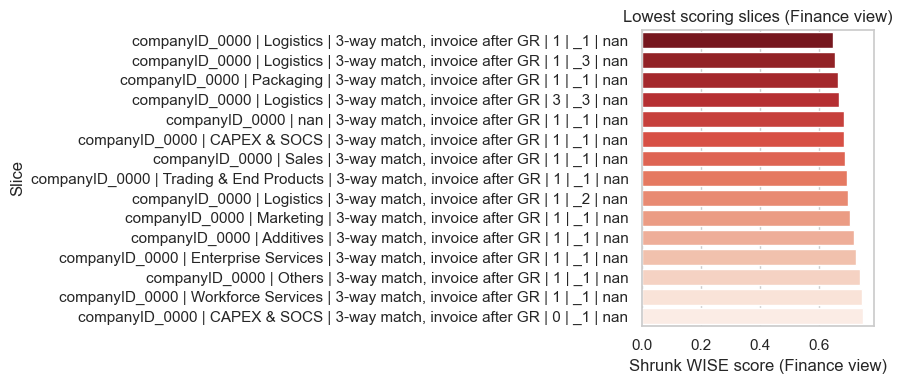

In [8]:
slice_cols = [c for c in ["case Company", "case Spend area text",
                          "case Item Category", "cluster",
                          "complexity_cluster", "auto_level"]
              if c in slice_summary.columns]

# pick the worst 15 slices by shrunk score
worst_slices = slice_summary.sort_values(shrunk_col).head(15).copy()
worst_slices["SliceLabel"] = worst_slices[slice_cols].astype(str).agg(" | ".join, axis=1)

plt.figure(figsize=(9,4))
sns.barplot(x=worst_slices[shrunk_col], y=worst_slices["SliceLabel"],
            palette="Reds_r", orient="h")
plt.xlabel("Shrunk WISE score (Finance view)")
plt.ylabel("Slice")
plt.title("Lowest scoring slices (Finance view)")
plt.tight_layout()
plt.show()

**Reading this chart.**

For each bar you see:

- the **segment** (company/spend area/item category and behavioural clusters),
- its **shrunk WISE score** (Finance view),
- the slices at the top of the chart are **closest to the norm**, slices at the bottom diverge more.

Combine this with `PI`:

In [9]:
worst_pi = slice_summary.sort_values("PI", ascending=False).head(15).copy()
worst_pi["SliceLabel"] = worst_pi[slice_cols].astype(str).agg(" | ".join, axis=1)
worst_pi[["SliceLabel", "n_cases", "mean_score", "shrunk_score", "gap", "PI"]]

,SliceLabel,n_cases,mean_score,shrunk_score,gap,PI
1,"companyID_0000 | Logistics | 3-way match, invo...",1261,0.647351,0.653895,0.166900,210.460902
0,"companyID_0000 | Logistics | 3-way match, invo...",1006,0.641091,0.649511,0.173160,174.199318
2,"companyID_0000 | Packaging | 3-way match, invo...",537,0.652210,0.666410,0.162042,87.016287
3,"companyID_0000 | Logistics | 3-way match, invo...",419,0.649463,0.667529,0.164788,69.046299
6,"companyID_0000 | Sales | 3-way match, invoice ...",266,0.663647,0.688215,0.150605,40.060849
7,companyID_0000 | Trading & End Products | 3-wa...,234,0.670481,0.696615,0.143771,33.642307
5,"companyID_0000 | CAPEX & SOCS | 3-way match, i...",164,0.645884,0.686313,0.168367,27.612215
8,"companyID_0000 | Logistics | 3-way match, invo...",101,0.641832,0.700470,0.172420,17.414382
4,"companyID_0000 | nan | 3-way match, invoice af...",79,0.598734,0.684078,0.215517,17.025854
9,"companyID_0000 | Marketing | 3-way match, invo...",104,0.652380,0.706451,0.161872,16.834636


This gives you a short list of **where to look first**.

---

## 3. More heatmaps: layer-wise deviations by dimension

To understand what type of problem each slice has, we use **layer-wise
violations**. If you have per-case layer violation columns (e.g.
`violation_presence`, `violation_order_lag`, etc.), you can create new
heatmaps by different dimensions.

Here we assume you already computed a `heat_data` matrix for

- rows = `case Spend area text | case Item Category`,
- columns = WISE layers.

Let us create more.

### 3.1. Company × Spend area × Item Category

In [19]:
case_full.head()

,case concept:name,score,violation_exclusion,violation_order_lag,violation_presence,violation_singularity,viol_c_l1_create_po,viol_c_l1_gr,viol_c_l1_inv,viol_c_l1_clear,...,inv_to_clear_cluster,auto_level,complexity_score,complexity_cluster,throughput_days,throughput_cluster,start_season,start_weekpart,start_dayofweek,full_slice
0,2000000001_00001,0.916667,0.00,0.222222,0.00,0.0,0.0,0.0,0.0,0.0,...,_2,NaN,0.613284,_4,63.0,_4,Q1,weekday,Wed,"companyID_0000 | Marketing | 3-way match, invo..."
1,2000000002_00001,0.850000,0.25,0.333333,0.00,0.0,0.0,0.0,0.0,0.0,...,_5,NaN,0.663133,_4,223.0,_1,Q1,weekday,Thu,"companyID_0000 | Marketing | 3-way match, invo..."
2,2000000005_00002,0.575000,0.00,1.000000,0.75,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,0.304213,_1,NaN,NaN,Q1,weekday,Mon,companyID_0000 | Workforce Services | 3-way ma...
3,2000000006_00001,0.941667,0.00,0.155556,0.00,0.0,0.0,0.0,0.0,0.0,...,_2,NaN,0.613284,_4,44.0,_5,Q1,weekday,Mon,"companyID_0000 | Marketing | 3-way match, invo..."
4,2000000008_00001,0.975000,0.00,0.066667,0.00,0.0,0.0,0.0,0.0,0.0,...,_2,NaN,0.504784,_3,44.0,_5,Q1,weekday,Mon,companyID_0000 | Enterprise Services | 3-way m...


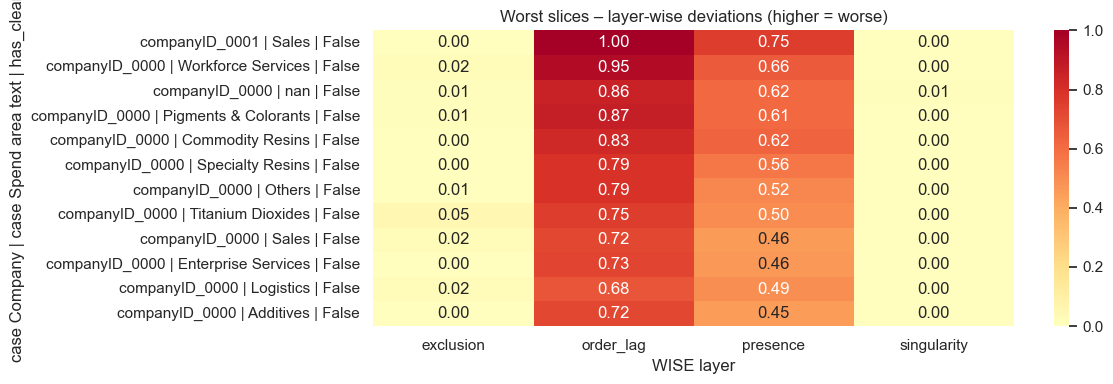

In [21]:
# assume you have a full-case table with violations and slice labels
# 'case_full_raw' would come from your original WISE pipeline;
# here, we re-use 'features' and join on case id if needed.

# Example: join 'features' with a separate table 'scores' if you have it
# scores = pd.read_csv(DATA_DIR / "Case_Scores.csv")
# case_full_raw = features.merge(scores, on="case concept:name", how="left")

# For illustration, assume 'case_full_raw' is available with:
# - WISE violation columns starting with 'violation_'
# - attributes case Company, case Spend area text, case Item Category

def show_violations_threefold_heatmap(case_full: pd.DataFrame, 
                                      first_slice: str = "case Company",
                                      second_slice: str = "case Spend area text",
                                      third_slice: str = "case Item Category"):

    violation_cols = [c for c in case_full.columns if c.startswith("violation_")]

    case_full["full_slice"] = (
        case_full[first_slice].astype(str) + " | " +
        case_full[second_slice].astype(str) + " | " +
        case_full[third_slice].astype(str)
    )

    layer_means = (
        case_full.groupby("full_slice")[violation_cols]
        .mean()
        .reset_index()
    )

    layer_means["mean_badness"] = layer_means[violation_cols].mean(axis=1)
    top_full_slices = layer_means.sort_values("mean_badness", ascending=False).head(12)

    heat_data_full = top_full_slices.set_index("full_slice")[violation_cols]
    heat_data_full.columns = [c.replace("violation_", "") for c in heat_data_full.columns]

    plt.figure(figsize=(12,4))
    sns.heatmap(heat_data_full, cmap="RdYlGn_r", center=0, annot=True, fmt=".2f")
    plt.xlabel("WISE layer")
    #create label combining the three slice dimensions
    plt.ylabel(f"{first_slice} | {second_slice} | {third_slice}")
    plt.title("Worst slices – layer-wise deviations (higher = worse)")
    plt.tight_layout()
    plt.show()

show_violations_threefold_heatmap(case_full, third_slice="has_clear")

**Business implications.**

This heatmap tells you, for each **concrete segment** of the business:

- whether problems are primarily **missing steps** (L1),
- **slow or inverted sequences** (L2),
- **value mismatches** (L3),
- **rework / repeated changes** (L4),
- or **forbidden patterns** (L5).

For BPIC’19 P2P, you will typically see:

- Logistics and some CAPEX/Services slices showing strong **L3** and **L4**
  deviations (many GRs, price changes, and mismatch between GR and INV),
- some slices in other spend areas having mainly **L2** issues (slow invoice
  approval and clearing).

---

## 4. SHAP: explaining badness from engineered features

Now we turn to **case-level explanations**: how do engineered features like
lead times, counts, automation ratio, and multiplicity relate to **WISE
badness**?

### 4.1. Prepare ML dataset

We join `features` with per-case WISE scores. If you have a case-level table
with `score` (overall WISE score per case), load it here:

In [11]:
scores = data["case_scores"]
scores.head()

,case concept:name,score,violation_exclusion,violation_order_lag,violation_presence,violation_singularity,viol_c_l1_create_po,viol_c_l1_gr,viol_c_l1_inv,viol_c_l1_clear,...,viol_c_l2_inv_to_clear,viol_c_l4_change_price_once,viol_c_l4_change_quantity_once,viol_c_l4_change_currency_once,viol_c_l4_change_payment_terms_once,viol_c_l5_cancel_invoice,viol_c_l5_cancel_gr,viol_c_l5_subsequent_invoice,viol_c_l5_subsequent_credit,badness
0,2000000001_00001,0.916667,0.00,0.222222,0.00,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
1,2000000002_00001,0.850000,0.25,0.333333,0.00,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.150000
2,2000000005_00002,0.575000,0.00,1.000000,0.75,0.0,0.0,1.0,1.0,1.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425000
3,2000000006_00001,0.941667,0.00,0.155556,0.00,0.0,0.0,0.0,0.0,0.0,...,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058333
4,2000000008_00001,0.975000,0.00,0.066667,0.00,0.0,0.0,0.0,0.0,0.0,...,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025000


Merge with `features`:

In [12]:
CASE_COL = "case concept:name"

df_ml = features.merge(scores[[CASE_COL, "score"]], on=CASE_COL, how="left")
df_ml["badness"] = 1.0 - df_ml["score"]  # higher = worse

df_ml = df_ml.dropna(subset=["badness"])
df_ml.head()

,case concept:name,first_po,first_gr,first_inv,first_clear,po_to_gr_days,gr_to_inv_days,inv_to_clear_days,n_events,n_gr,...,has_gr,has_inv,has_clear,n_multi_activities,sum_multi_events,n_multi_change_activities,sum_multi_change_events,cluster,score,badness
0,2000000001_00001,2018-01-03 10:49:00,2018-01-16 13:09:00,2018-01-16 15:44:00,2018-03-08 13:21:00,13.0,0.0,50.0,15,1,...,True,True,True,1,2,0,0,0,0.916667,0.083333
1,2000000002_00001,2018-01-04 15:17:00,2018-02-06 15:53:00,2018-08-16 12:41:00,2018-08-16 15:03:00,33.0,190.0,0.0,18,2,...,True,True,True,3,6,0,0,0,0.850000,0.150000
2,2000000005_00002,2018-01-08 11:09:00,NaN,NaN,NaN,NaN,NaN,NaN,8,0,...,False,False,False,0,0,0,0,1,0.575000,0.425000
3,2000000006_00001,2018-01-08 12:33:00,2018-01-09 10:04:00,2018-01-09 12:59:00,2018-02-23 12:14:00,0.0,0.0,44.0,15,1,...,True,True,True,1,2,0,0,0,0.941667,0.058333
4,2000000008_00001,2018-01-08 16:36:00,2018-01-15 12:53:00,2018-01-17 15:49:00,2018-02-22 16:18:00,6.0,2.0,36.0,13,1,...,True,True,True,0,0,0,0,0,0.975000,0.025000


The feature columns we have (from `features.csv`) are:

In [13]:
features.columns

Index(['case concept:name', 'first_po', 'first_gr', 'first_inv', 'first_clear',
       'po_to_gr_days', 'gr_to_inv_days', 'inv_to_clear_days', 'n_events',
       'n_gr', 'n_inv', 'n_clear', 'n_price_changes', 'n_users', 'start_ts',
       'start_dow', 'start_month', 'n_auto_events', 'n_manual_events',
       'auto_ratio', 'has_gr', 'has_inv', 'has_clear', 'n_multi_activities',
       'sum_multi_events', 'n_multi_change_activities',
       'sum_multi_change_events', 'cluster'],
      dtype='object')

We choose a subset that is interpretable and numeric:

In [14]:
feature_cols = [
    "po_to_gr_days", "gr_to_inv_days", "inv_to_clear_days",
    "n_events", "n_gr", "n_inv", "n_clear", "n_price_changes",
    "n_users",
    "start_dow", "start_month",
    "n_auto_events", "n_manual_events", "auto_ratio",
    "n_multi_activities", "sum_multi_events",
    "n_multi_change_activities", "sum_multi_change_events",
]

X = df_ml[feature_cols].fillna(0.0).values.astype("float64")
y = df_ml["badness"].values

### 4.2. Train a simple RandomForest and compute SHAP values

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)
print("R² on holdout:", rf.score(X_test, y_test))

R² on holdout: 0.9879336787185817


Compute SHAP:

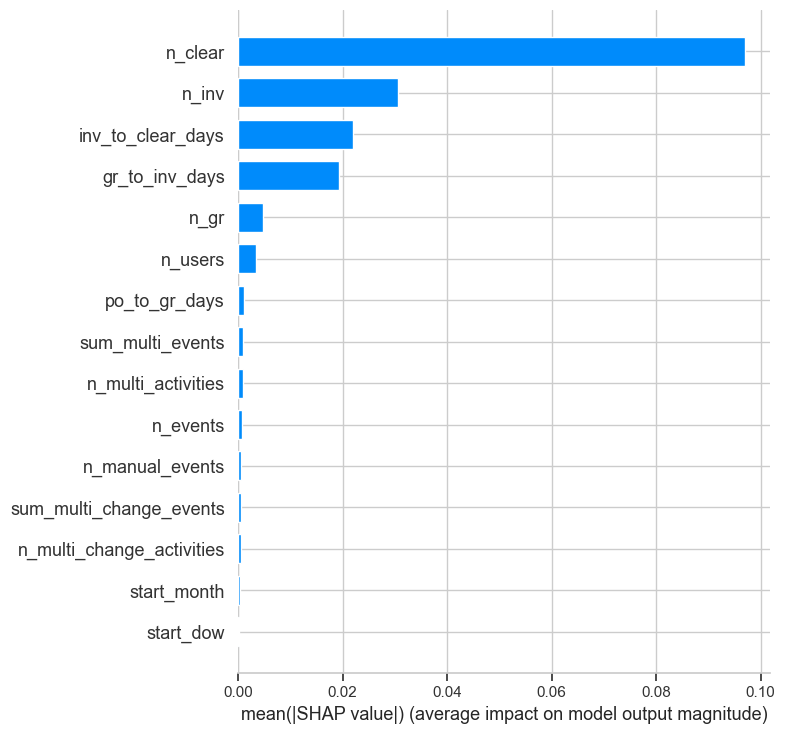

In [16]:
explainer = shap.TreeExplainer(rf)
X_test_enc = X_test.astype(np.float64)
shap_values = explainer.shap_values(X_test_enc)

shap.summary_plot(
    shap_values,
    X_test_enc,
    feature_names=feature_cols,
    plot_type="bar",
    max_display=15,
)

**How to read the SHAP summary.**

- Each bar is a feature; longer bars = more **impact on badness**.
- If you see `n_price_changes` and `gr_to_inv_days` at the top, it means:

  - many price changes,
  - long GR→INV intervals

  are strong drivers of high WISE badness (poor process behaviour) in the
  Finance view.

### 4.3. SHAP for a specific bad case

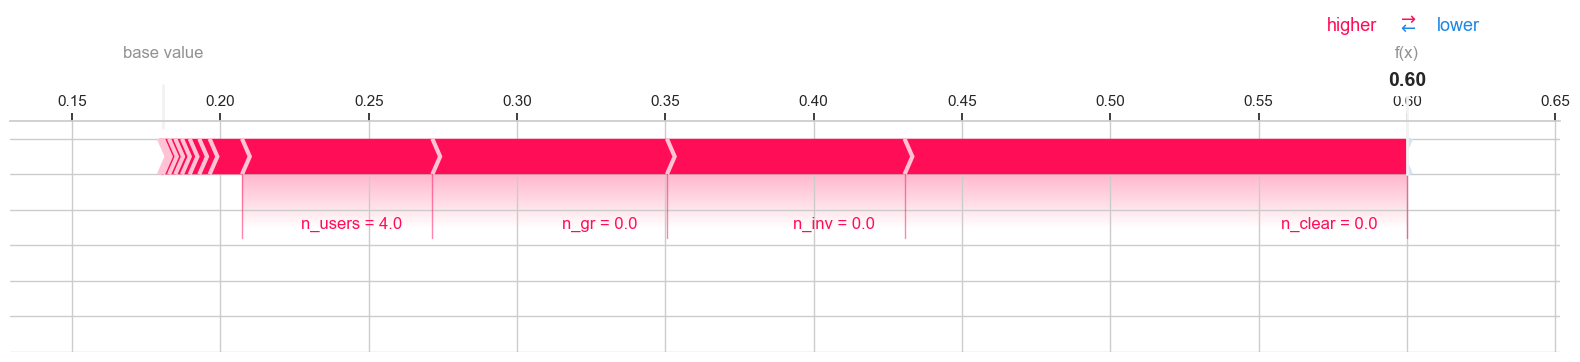

In [17]:
# pick one of the worst cases in the test set
idx = np.argsort(-y_test)[0]
x_instance = X_test_enc[idx:idx+1]
shap_values_single = explainer.shap_values(x_instance)

shap.force_plot(
    explainer.expected_value,
    shap_values_single,
    x_instance,
    feature_names=feature_cols,
    matplotlib=True,
)

This plot tells you, for a specific case:

- which features (e.g. *3 price changes*, *5 GRs*, *low auto_ratio*,
  *start_dow = Friday*) pushed its badness up,
- which features mitigated it (few users, short INV→CLEAR, etc.).

From a business perspective, you would say:

> *“This case is bad because it has multiple price changes, a long GR→INV
> delay, very low automation and many repeated activities – typical for
> Logistics 3-way after GR with manual rework.”*

---

## 5. LIME: alternative local explanations (optional)

For additional local explanations, LIME can produce an interpretable table
of conditional contributions.

In [18]:
from lime.lime_tabular import LimeTabularExplainer

explainer_lime = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_cols,
    mode="regression",
)

exp = explainer_lime.explain_instance(
    X_test[0],
    rf.predict,
    num_features=10,
)
exp.show_in_notebook(show_table=True)

This table lists feature thresholds (e.g. `inv_to_clear_days > 30`, `n_price_changes ≥ 2`) and their contributions to the predicted badness.

---

## 6. Business workflow: how to use these results

### 6.1. From heatmaps and PI to problem statements

With the heatmaps and bar charts, you can formulate slices like:

1. **companyID_0000 | Logistics | 3-way after GR**

   - Lowest shrunk WISE scores.
   - High L3 Balance and L4 Singularity violations.
   - SHAP shows `n_price_changes`, `n_gr`, `gr_to_inv_days` as key drivers.
   - Interpretation:
     - Logistics P2P in this company has many partial GRs, frequent price
       changes after GR, and long GR→INV delays.
     - This leads to manual work in matching and increases blocked invoice days.

2. **companyID_0000 | CAPEX & SOCS | 3-way after GR**

   - Moderate shrinking but still poor L2 Order/Lag.
   - SHAP: `inv_to_clear_days` stands out.
   - Interpretation:
     - CAPEX projects suffer from long invoice clearance times, possibly due to
       complex approval chains.

3. **companyID_0000 | Enterprise Services | 3-way after GR**

   - Scores are better but still show L2 issues in some clusters.
   - Interpretation:
     - Service purchases may have incomplete or late confirmations, leading to
       slower invoice processing.

### 6.2. BPIC’19 domain specifics and improvement levers

BPIC’19 is special in that it:

- covers **non-product-related spend** (marketing, logistics, services, etc.),
- shows many **complex service and logistics lines**, where:

  - goods receipts can be repeated and fragmented,
  - price changes occur late in the process,
  - approval flows often involve several users and manual interventions.

Based on WISE + SHAP analysis, typical improvement ideas include:

1. **Standardise logistics GR practices**

   - Constraint: one or a small number of GRs per PO line; GR quantities should
     match planned quantities within a narrow tolerance.
   - Actions:
     - Consolidate GR into fewer postings (avoid dozens of small GRs).
     - Enforce timeliness of GR posting (no late retro entries).
     - Monitor L3/L4 violations for Logistics slices and track regression.

2. **Tighten price change policy after GR (L4/L5)**

   - Norm: price changes after GR should be rare exceptions.
   - Actions:
     - Shift negotiation and price confirmation earlier in the process.
     - Require higher-level approvals for late price changes.
     - Automate blocking of invoices when price changes occur after GR until a
       justification is recorded.

3. **Simplify and automate invoice approval (CAPEX & Services)**

   - Norm: defined thresholds for INV→CLEAR duration (e.g. target medians).
   - Actions:
     - Analyse approval chains (number of users, manual events) in slices with
       high L2 violations.
     - Introduce automatic reminders and escalations.
     - Automate approvals below certain amounts or in low-risk categories.

4. **Increase touchless processing for well-behaved clusters**

   - Use clusters and automation ratio:
     - Identify segments where scores are good but manual events are still
       common.
   - Actions:
     - Automate more steps (e.g. auto-match based on three-way norm),
     - Extend vendor/self-service portals,
     - Track WISE scores pre/post-automation to ensure quality remains stable.

5. **Use WISE as a monitoring & governance tool**

   - For each quarterly/monthly run:
     - recompute case scores and slice-level PI,
     - monitor changes for previously bad slices,
     - check that improvements are reflected in higher shrunk scores,
       better layer profiles, and lower PI.

---

## 7. Putting it all together – your P2P analysis workflow

Combining everything in this notebook, a **WISE-driven P2P workflow** for
BPIC’19 looks like:

1. **Load and profile** the P2P log (event counts, cases, attributes).
2. **Engineer per-case features** (durations, counts, multiplicity, automation,
   cluster).
3. **Compute WISE scores and layer violations** per case.
4. **Aggregate at slice level** (Company × Spend area × Item type × cluster),
   compute shrunk scores, gap, and PI.
5. **Visualise and rank** slices using bar charts, heatmaps, and
   severity-vs-volume scatter.
6. **Use SHAP/LIME** on `badness` to understand which case-level features are
   driving deviations.
7. **Formulate improvement initiatives** focused on slices that are both
   impactful (high PI) and highly interpretable (clear dominant layers/features).
8. **Iterate and monitor**: run WISE periodically, track progress, and refine
   norms and automation policies.

This closes the loop from raw P2P event data to **norm-based, explainable,
prioritised improvements** that speak the language of the business (blocked
days, rework, automation, compliance with 3-way/2-way/consignment rules) and
are rooted in the realities of the BPIC'19 domain.
